In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [2]:
train_path = "../data/UNSW_NB15_training-set.csv"
test_path = "../data/UNSW_NB15_testing-set.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("Train shape: ", train_df.shape)
print("Test shape :", test_df.shape)

Train shape:  (175341, 45)
Test shape : (82332, 45)


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

In [4]:
train_df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [5]:
# Checking the distribution of classes

train_df['label'].value_counts()

label
1    119341
0     56000
Name: count, dtype: int64

In [6]:
# Dropping non-feature columns

DROP_COLS = ['id', 'attack_cat', 'label']

X_train = train_df.drop(columns=DROP_COLS, errors='ignore')
X_test = test_df.drop(columns=DROP_COLS, errors="ignore")

y_train = train_df['label']
y_test = test_df['label']

print(X_train.shape, X_test.shape)

(175341, 42) (82332, 42)


In [7]:
# one hot encoding
categorical_cols = ['proto', 'service', 'state']

combined = pd.concat([X_train, X_test], axis=0)

combined_encoded = pd.get_dummies(
    combined,
    columns=categorical_cols,
    drop_first=True
)

X_train = combined_encoded.iloc[:len(X_train)].copy()
X_test = combined_encoded.iloc[len(X_train):].copy()

print("After encoding:")
print(X_train.shape, X_test.shape)

After encoding:
(175341, 193) (82332, 193)


In [8]:
# Handling missing/ infinite values

def clean_numeric(df):
    df = df.copy()
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(df.median(), inplace=True)
    return df

X_train = clean_numeric(X_train)
X_test = clean_numeric(X_test)
    

In [9]:
# Training only on normal traffic

X_train_normal = X_train[y_train==0]

print("Normal-only training data shape:", X_train_normal.shape)

Normal-only training data shape: (56000, 193)


In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_normal)
X_test_scaled = scaler.transform(X_test)

### Isolation forest

In [ ]:
# Cross Validation to tune n_estimators and contamination (Isolation Forest)



In [12]:
iso = IsolationForest(
    n_estimators = 400,
    contamination="auto",
    random_state=42,
    n_jobs=-1    
)

iso.fit(X_train_scaled)

,"n_estimators n_estimators: int, default=100The number of base estimators in the ensemble.",400
,"max_samples max_samples: ""auto"", int or float, default=""auto""The number of samples to draw from X to train each base estimator.- If int, then draw `max_samples` samples.- If float, then draw `max_samples * X.shape[0]` samples.- If ""auto"", then `max_samples=min(256, n_samples)`.If max_samples is larger than the number of samples provided,all samples will be used for all trees (no sampling).",'auto'
,"contamination contamination: 'auto' or float, default='auto'The amount of contamination of the data set, i.e. the proportionof outliers in the data set. Used when fitting to define the thresholdon the scores of the samples.- If 'auto', the threshold is determined as in the original paper.- If float, the contamination should be in the range (0, 0.5]... versionchanged:: 0.22 The default value of ``contamination`` changed from 0.1 to ``'auto'``.",'auto'
,"max_features max_features: int or float, default=1.0The number of features to draw from X to train each base estimator.- If int, then draw `max_features` features.- If float, then draw `max(1, int(max_features * n_features_in_))` features.Note: using a float number less than 1.0 or integer less than number offeatures will enable feature subsampling and leads to a longer runtime.",1.0
,"bootstrap bootstrap: bool, default=FalseIf True, individual trees are fit on random subsets of the trainingdata sampled with replacement. If False, sampling without replacementis performed.",False
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for :meth:`fit`. ``None`` means 1unless in a :obj:`joblib.parallel_backend` context. ``-1`` means usingall processors. See :term:`Glossary ` for more details.",-1
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseudo-randomness of the selection of the featureand split values for each branching step and each tree in the forest.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",42
,"verbose verbose: int, default=0Controls the verbosity of the tree building process.",0
,"warm_start warm_start: bool, default=FalseWhen set to ``True``, reuse the solution of the previous call to fitand add more estimators to the ensemble, otherwise, just fit a wholenew forest. See :term:`the Glossary `... versionadded:: 0.21",False


In [13]:
# predict: 1=Normal, -1=anomaly
# decision_function: higher= more normal, lower = more anomalous

pred = iso.predict(X_test_scaled)  #1 normal, -1 anomaly
is_anomaly = (pred == -1).astype(int) # 1 anomaly, 0 normal

# Converting decision_function to an anomaly score
anomaly_score = -iso.decision_function(X_test_scaled)

print("Predicted anomalies: ", is_anomaly.sum(), "out of", len(is_anomaly) )

Predicted anomalies:  19103 out of 82332


In [15]:
auc = roc_auc_score(y_test, anomaly_score)
print("ROC-AUC (higher is better): ", auc)

print("\n Confusion Matrix (rows=true, cols=pred): ")
print(confusion_matrix(y_test, is_anomaly))

print("\n Classification Report: ")
print(classification_report(y_test, is_anomaly, digits=4))
      
    

ROC-AUC (higher is better):  0.7877172682145659

 Confusion Matrix (rows=true, cols=pred): 
[[34159  2841]
 [29070 16262]]

 Classification Report: 
              precision    recall  f1-score   support

           0     0.5402    0.9232    0.6816     37000
           1     0.8513    0.3587    0.5048     45332

    accuracy                         0.6124     82332
   macro avg     0.6958    0.6410    0.5932     82332
weighted avg     0.7115    0.6124    0.5842     82332



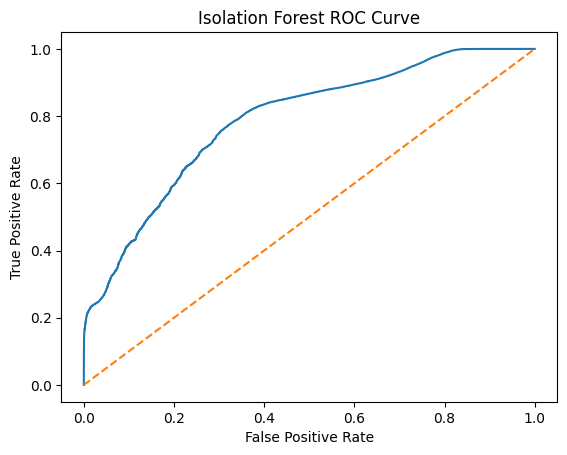

In [17]:
fpr, tpr, _ = roc_curve(y_test, anomaly_score)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Isolation Forest ROC Curve")
plt.show()